# Analise Exploratória de Dados

In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy.stats import kendalltau
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

sns.set(style="darkgrid")
tqdm.pandas()

/tmp/ipykernel_28563/971503677.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Carregamento dos Dados

Para a análise, vamos primeiro dividir os dados da mesma forma que durante o treinamento do modelo. A análise será realizada na base de treino para evitar vazamento de dados.

In [2]:
DATA_PATH = "../_data/dataset_2021-5-26-10-14.csv"


def load_data():
    data = pd.read_csv(DATA_PATH, sep="\t", encoding="utf8", na_values="missing")
    train, test = train_test_split(
        data, test_size=0.2, stratify=data["default"], shuffle=True, random_state=0
    )
    return train, test


data, _ = load_data()

## Análise Inicial

In [4]:
data.shape

(93818, 22)

In [5]:
data.head()

,default_3months,ioi_36months,ioi_3months,valor_por_vencer,valor_vencido,valor_quitado,quant_protestos,valor_protestos,quant_acao_judicial,acao_judicial_valor,...,dividas_vencidas_qtd,falencia_concordata_qtd,tipo_sociedade,opcao_tributaria,atividade_principal,forma_pagamento,valor_total_pedido,month,year,default
85316,0,133.000000,17.941883,0.00,0.0,90755.55,0,0.0,0,0.0,...,0,0,sociedade empresaria limitada,simples nacional,com de eletrodomesticos,28/35/42 dd,28342.406159,8,2019,0
94814,0,272.000000,18.245173,10310.86,0.0,0.00,0,0.0,0,0.0,...,0,0,empresario (individual),simples nacional,com de telefones e equip p/ comunicacoes,30/60/90,3773.144153,6,2018,0
91803,0,72.666667,63.000000,4688.11,0.0,37810.92,0,0.0,0,0.0,...,0,0,empresario (individual),simples nacional,com de confeccoes em geral,30/60/90,2392.068367,9,2017,0
64498,0,107.033333,10.201515,0.00,0.0,19604.76,0,0.0,0,0.0,...,0,0,empresa individual respons limitada empresaria,simples nacional,papelaria,42/49/56/63/70,2220.607501,4,2017,0
40607,0,14.411765,11.833333,2844.28,0.0,124477.15,0,0.0,0,0.0,...,0,0,empresario (individual),simples nacional,com de equipamentos de informatica,NaN,1510.317835,10,2017,0


In [6]:
data[data.duplicated()]

,default_3months,ioi_36months,ioi_3months,valor_por_vencer,valor_vencido,valor_quitado,quant_protestos,valor_protestos,quant_acao_judicial,acao_judicial_valor,...,dividas_vencidas_qtd,falencia_concordata_qtd,tipo_sociedade,opcao_tributaria,atividade_principal,forma_pagamento,valor_total_pedido,month,year,default


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93818 entries, 85316 to 63921
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   default_3months              93818 non-null  int64  
 1   ioi_36months                 93818 non-null  float64
 2   ioi_3months                  93818 non-null  float64
 3   valor_por_vencer             93818 non-null  float64
 4   valor_vencido                93818 non-null  float64
 5   valor_quitado                93818 non-null  float64
 6   quant_protestos              93818 non-null  int64  
 7   valor_protestos              93818 non-null  float64
 8   quant_acao_judicial          93818 non-null  int64  
 9   acao_judicial_valor          93818 non-null  float64
 10  participacao_falencia_valor  93818 non-null  float64
 11  dividas_vencidas_valor       93818 non-null  float64
 12  dividas_vencidas_qtd         93818 non-null  int64  
 13  falencia_concorda

In [8]:
numeric = data.select_dtypes(["float64", "int64"])

missing_frac = data.isna().sum() / len(data)
missing_frac = missing_frac[missing_frac > 0]
missing_frac.to_frame("missing_frac")

,missing_frac
tipo_sociedade,0.005180
opcao_tributaria,0.156654
atividade_principal,0.005010
forma_pagamento,0.276887


## Target (default)


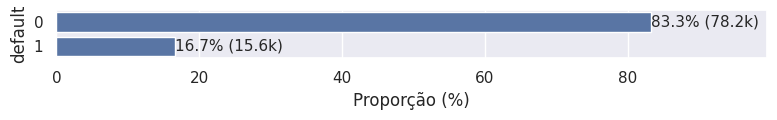

In [9]:
def format_proportion(proportion: int, total: int):
    count = int(round(proportion * total / 100))
    if count < 1e3:
        count_str = str(count)
    else:
        count_str = f"{count/1e3:.1f}k"
    return f"{proportion:.1f}% ({count_str})"


def plot_proportions(x: pd.Series, limit: int | None = None):
    props = x.value_counts() / len(x) * 100
    if limit is not None:
        props = props.iloc[:limit]

    plt.figure(figsize=(8, 0.86 + 0.25 * len(props)))
    ax = sns.barplot(props, orient="h")
    labels = plt.bar_label(
        ax.containers[0], fmt=lambda p: format_proportion(p, len(x)), size=11
    )
    plt.xlabel("Proporção (%)")

    # Increase the limit on x-axis to make space for the bar labels
    _, xmax = plt.xlim()
    for label in labels:
        # for each bar label, get its position on the figure (in pixels)
        # and convert it to the data coordinates
        label_bbox = label.get_window_extent().transformed(ax.transData.inverted())
        xmax = max(xmax, label_bbox.x1 + 1)
    plt.xlim(None, xmax)

    plt.tight_layout()


plot_proportions(data["default"])

O dataset é desbalanceado, com apenas 16.7% de default.

## Variáveis Numéricas

### Erros de Anotação

No dataset, existem três pares de variáveis do tipo contagem/valor:

- `quant_protestos`/`valor_protestos`
- `dividas_vencidas_qtd`/`dividas_vencidas_valor`
- `quant_acao_judicial`/`acao_judicial_valor`

Para cada par de colunas, espera-se que um dos casos a seguir aconteça:
- Ambas as colunas são zero (eg. não há nenhum protesto, logo o valor dos protestos também é zero)
- Nenhum das colunas é zero (eg. há protestos, logo há um valor de protestos)

A seguir, vou verificar essa expectativa.

Observação: aqui, estou considerando que as ações judiciais do dataset sempre buscam compensação financeira. Essa consideração será discutida em breve.

In [10]:
def validate_count_and_value(count_col: str, value_col: str):
    count_is_zero = data[count_col] == 0
    value_is_zero = data[value_col] == 0

    print(f"{count_col}/{value_col}:")

    invalid1 = count_is_zero & ~value_is_zero
    if invalid1.any():
        print(f"    {invalid1.sum():3d} linhas com quantidade == 0 e valor != 0")
    invalid2 = ~count_is_zero & value_is_zero
    if invalid2.any():
        print(f"    {invalid2.sum():3d} linhas com quantidade != 0 e valor == 0")

    if not (invalid2.any() or invalid1.any()):
        print("    OK")


validate_count_and_value("quant_protestos", "valor_protestos")
validate_count_and_value("dividas_vencidas_qtd", "dividas_vencidas_valor")
validate_count_and_value("quant_acao_judicial", "acao_judicial_valor")

quant_protestos/valor_protestos:
    587 linhas com quantidade == 0 e valor != 0
dividas_vencidas_qtd/dividas_vencidas_valor:
     65 linhas com quantidade == 0 e valor != 0
quant_acao_judicial/acao_judicial_valor:
     21 linhas com quantidade == 0 e valor != 0
    372 linhas com quantidade != 0 e valor == 0


Vemos que todos os três pares de variáveis apresentam linha com `quantidade == 0` e `valor != 0`. Por exemplo, para o caso de protestos, temos:

In [11]:
mask = (data["quant_protestos"] == 0) & (data["valor_protestos"] != 0)
data.loc[mask, ["quant_protestos", "valor_protestos"]]

,quant_protestos,valor_protestos
112029,0,507.486991
115352,0,4280.474640
111299,0,83.257486
109723,0,361.834236
102417,0,161.427033
...,...,...
114546,0,136.253629
107494,0,957.113932
102894,0,373.952041
114115,0,14810.787963


Nesses casos, assumo que a quantidade de protestos esteja errada (eg foi mantida no valor padrão = 0). Logo, a quantidade de protestos real é desconhecida. Para não influenciar as análises futuras, vou substituir a quantidade por NaN nesses casos:

In [12]:
mask = (data["quant_protestos"] == 0) & (data["valor_protestos"] != 0)
data.loc[mask, "quant_protestos"] = np.nan

mask = (data["dividas_vencidas_qtd"] == 0) & (data["dividas_vencidas_valor"] != 0)
data.loc[mask, "dividas_vencidas_qtd"] = np.nan

mask = (data["quant_acao_judicial"] == 0) & (data["acao_judicial_valor"] != 0)
data.loc[mask, "quant_acao_judicial"] = np.nan

A análise anterior também mostra 372 linhas em que `quant_acao_judicial != 0` e `acao_judicial_valor == 0`, ou seja, há ações judiciais, mas o seu valor é zero. Algumas explicações para esse fenômeno são:

- Existem ações judiciais sem valor financeiro (as ações buscam compensações não financeiras)
- Houve algum erro na obtenção do valor das ações / o dado está incorreto
- O valor da ação judicial ainda não foi definido ou não foi registrado no sistema do Serasa

Dado o contexto dos dados (provenientes do Serasa, junto com outros dados relativos à protestos e dividas), inicialmente assumi que as ações judiciais referiam-se exclusivamente a cobranças judiciais. No entanto, devido ao baixo número de linhas com essa discrepância, assim como ao fato de que esse modo de falha não ocorreu nos outros pares de variáveis analisados acima, acho possível que hajam realmente ações sem valor financeiro. Logo, não vou modificá-las.


### Variáveis com alta proporção de valor zero

Uma primeira análise da distribuição dos dados numéricos é mostrada a seguir. Além das estatísticas tradicionais, também estou analisando a porcentagem de zeros em cada variável (dada na coluna `percent_zero` na tabela abaixo).

In [13]:
numeric = data.select_dtypes(["float64", "int64"]).drop("default", axis=1)
stats = numeric.describe(percentiles=[]).T.drop(["count"], axis=1)
stats["percent_zero"] = (numeric == 0).mean()
stats = stats.sort_values("percent_zero")
with pd.option_context("display.float_format", lambda x: f"{x:.4f}"):
    display(stats)

,mean,std,min,50%,max,percent_zero
year,2017.9766,0.7426,2017.0000,2018.0000,2019.0000,0.0000
ioi_36months,55.6137,60.9820,1.0000,38.0000,951.0000,0.0000
ioi_3months,17.1095,10.9983,1.0000,16.0000,90.0000,0.0000
valor_total_pedido,23959.0448,527381.9770,-620.7552,4007.8404,150333994.6122,0.0000
month,6.2785,3.1956,1.0000,7.0000,12.0000,0.0000
valor_quitado,1071314.3767,7387300.0400,0.0000,81893.1050,460320322.8000,0.0401
valor_por_vencer,63630.3318,537078.5252,0.0000,4460.9450,72197586.3600,0.2132
valor_vencido,2509.7287,88401.4262,0.0000,0.0000,13150500.0000,0.8939
default_3months,0.1511,0.8696,0.0000,0.0000,26.0000,0.9236
quant_protestos,0.2190,8.7191,0.0000,0.0000,2324.0000,0.9561


A tabela revela que a maioria das variáveis numéricas tem uma proporção elevada de valores iguais a zero. Como caso extremo, a coluna `participacao_falencia_valor` é sempre zero. Por esse motivo, essa variável será removida.

In [14]:
data = data.drop("participacao_falencia_valor", axis=1, errors="ignore")

Também podemos verificar que as variáveis com alta proporção de zeros (de `valor_vencido` até `participacao_falencia_valor`) são todas relacionadas à inadimplência, incluindo defaults, pagamentos vencidos, protestos, etc. Essa ocorrência não é surpreendente e indica que a maioria dos clientes da X-Health não tem problemas de inadimplência. No entanto, o desbalanceamento dessas variáveis pode torná-las inadequadas para a tarefa de predição.

A seguir, vou analisar a distribuição dessas variáveis, **ignorando as linhas com valor zero**. Como a distrição original é extremamente assimétrica, várias das variáveis são mostradas em escala logaritmica.

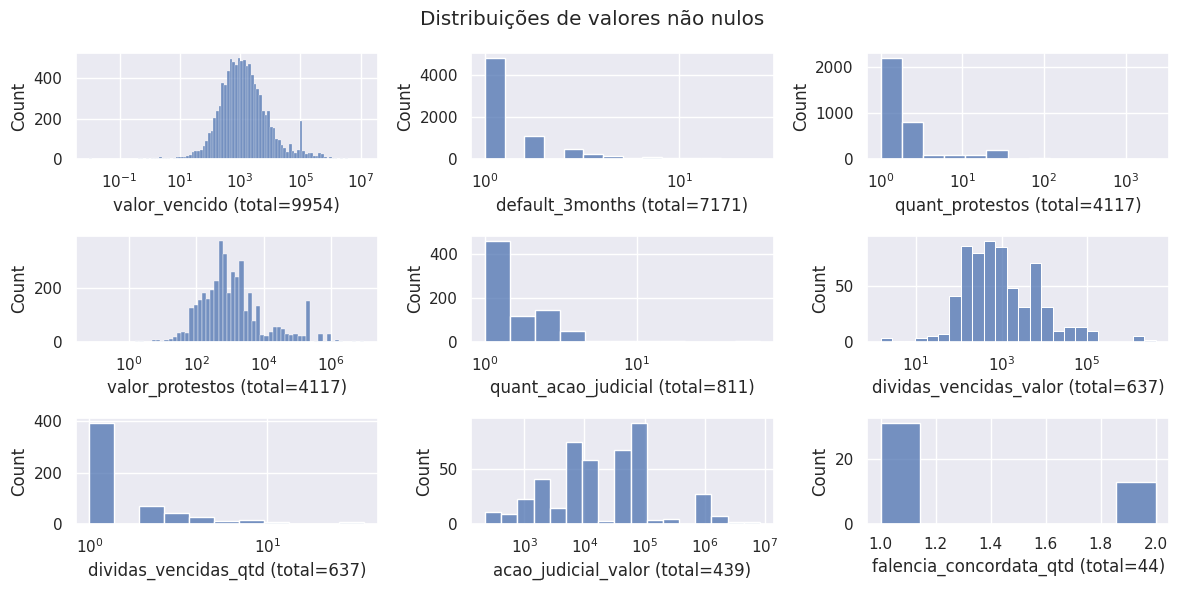

In [15]:
def plot_distribution_nonzero(subplot_spec: int, col: str, log: bool = False):
    plt.subplot(subplot_spec)
    filtered = data[data[col] != 0]
    discrete = "qtd" in col or "quant" in col or "default" in col
    sns.histplot(
        x=col,
        bins="sturges" if discrete else "auto",
        data=filtered,
        log_scale=(log, False),
    )
    plt.xlabel(f"{col} (total={len(filtered)})")


plt.figure(figsize=(12, 6))
plt.suptitle("Distribuições de valores não nulos")
plot_distribution_nonzero(331, "valor_vencido", log=True)
plot_distribution_nonzero(332, "default_3months", log=True)
plot_distribution_nonzero(333, "quant_protestos", log=True)
plot_distribution_nonzero(334, "valor_protestos", log=True)
plot_distribution_nonzero(335, "quant_acao_judicial", log=True)
plot_distribution_nonzero(336, "dividas_vencidas_valor", log=True)
plot_distribution_nonzero(337, "dividas_vencidas_qtd", log=True)
plot_distribution_nonzero(338, "acao_judicial_valor", log=True)
plot_distribution_nonzero(339, "falencia_concordata_qtd", log=False)

plt.tight_layout()

Analizando os plots acima, os valores não nulos parecem ter uma distribuição utilizável, após a utilização do log (ou power transform) para corrigir a distribuição dos dados. No entanto, o desbalancemanto extremo ainda pode dificultar qualquer análise utilizando essas variáveis. Esse efeito é particularmente forte para a variável `falencia_concordata_qtd`, que tem apenas 44 valores não nulos.

Uma tentativa de correção desse problema é a criação de uma nova variável, `qtd_indicadores_zero`, que conta o número de indicadores de inadimplência com valor zero (ou seja, valores baixos indicam clientes de alto risco). A expectativa é que essa variável tenha uma distribuição mais equilibrada.

In [16]:
zero_cols = [
    "valor_vencido",
    "default_3months",
    "quant_protestos",
    "valor_protestos",
    "quant_acao_judicial",
    "dividas_vencidas_valor",
    "dividas_vencidas_qtd",
    "acao_judicial_valor",
    "falencia_concordata_qtd",
]

data["qtd_indicadores_zero"] = (data[zero_cols] == 0).sum(axis=1)

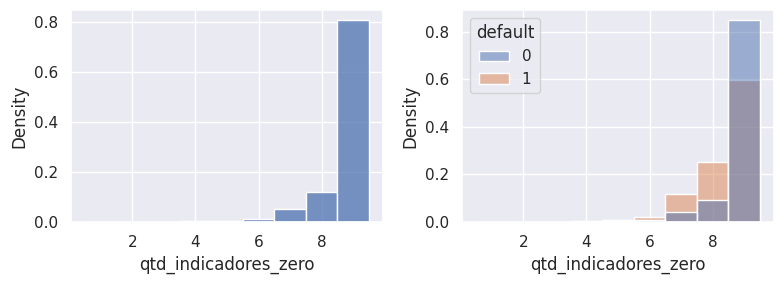

In [17]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
sns.histplot(
    x="qtd_indicadores_zero",
    stat="density",
    common_norm=False,
    data=data,
    discrete=True,
)
plt.subplot(122)
sns.histplot(
    x="qtd_indicadores_zero",
    stat="density",
    hue="default",
    common_norm=False,
    data=data,
    discrete=True,
)
plt.tight_layout()

A nova variável ainda é desbalanceada, mas muito menos do que as variáveis originais. Além disso, podemos notar uma diferença entre as distribuições com `default==0` e `default==1`. Para facilitar a comparação, o gráfico da direita mostra a distribuição de cada um dos casos, normalizados separadamente (ou seja, as áreas azul e laranja têm, cada uma, área 1).

### Outras variáveis financeiras numéricas

As outras variáveis financeiras numéricas exibem uma distribuição ainda assimétrica, mas muito menos do que as vistas acima.

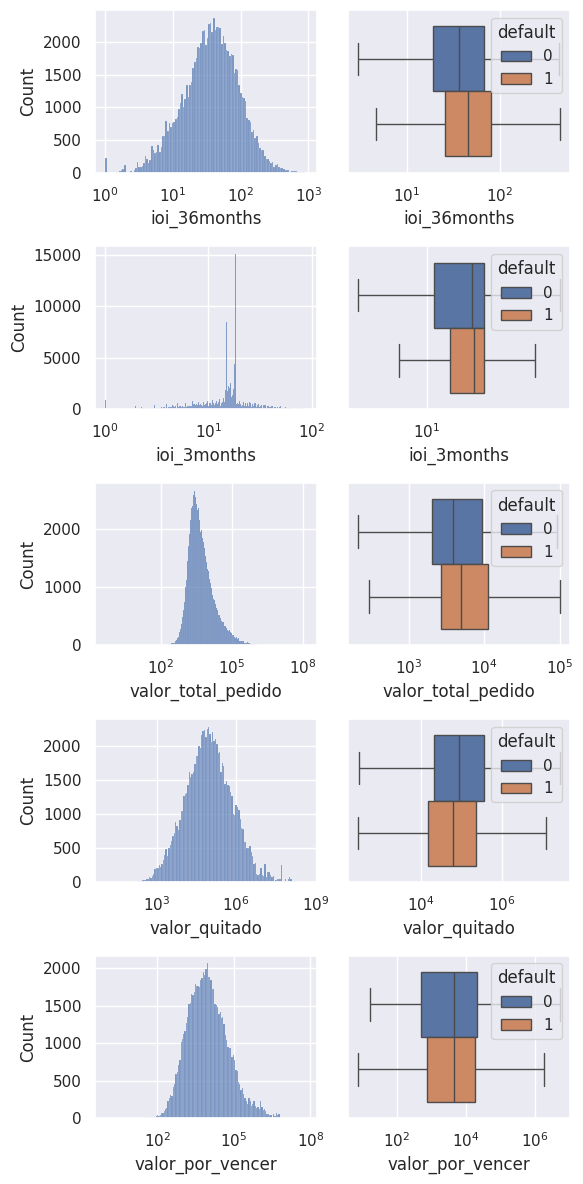

In [18]:
cols = [
    "ioi_36months",
    "ioi_3months",
    "valor_total_pedido",
    "valor_quitado",
    "valor_por_vencer",
]

plt.figure(figsize=(6, 12))
for i, col in enumerate(cols):
    plt.subplot(5, 2, 2 * i + 1)
    sns.histplot(x=col, data=data, log_scale=(True, False))

    plt.subplot(5, 2, 2 * i + 2)
    sns.boxplot(
        x=col,
        data=data,
        log_scale=(True, False),
        showfliers=False,
        hue="default",
    )
plt.tight_layout()

Por outro lado, a variável `valor_total_pedido` possui valores negativos:

In [19]:
data[cols].describe()

,ioi_36months,ioi_3months,valor_total_pedido,valor_quitado,valor_por_vencer
count,93818.000000,93818.000000,9.381800e+04,9.381800e+04,9.381800e+04
mean,55.613738,17.109524,2.395904e+04,1.071314e+06,6.363033e+04
std,60.982032,10.998325,5.273820e+05,7.387300e+06,5.370785e+05
min,1.000000,1.000000,-6.207552e+02,0.000000e+00,0.000000e+00
25%,20.217046,11.121543,2.131604e+03,1.946813e+04,5.647941e+02
50%,38.000000,16.000000,4.007840e+03,8.189310e+04,4.460945e+03
75%,69.563477,18.250000,9.692726e+03,3.313116e+05,2.002504e+04
max,951.000000,90.000000,1.503340e+08,4.603203e+08,7.219759e+07


Número de valores negativos: 114
Número de defaults nesses pedidos: 10
Número de valores zero: 0


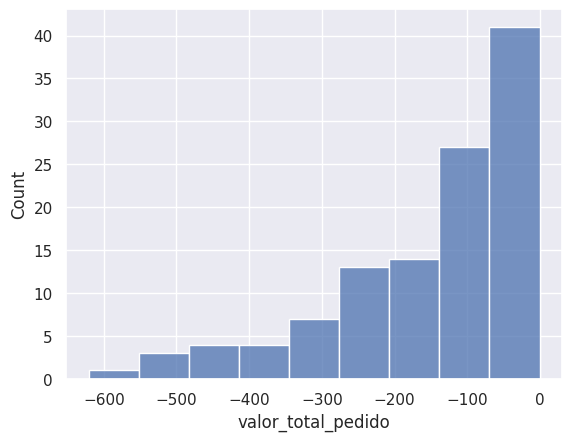

In [20]:
filtered = data[data["valor_total_pedido"] < 0]
sns.histplot(x="valor_total_pedido", data=filtered)
print("Número de valores negativos:", len(filtered))
print("Número de defaults nesses pedidos:", filtered["default"].sum())
print("Número de valores zero:", (data["valor_total_pedido"]==0).sum())

Dado o baixo número de valores, é possível que eles representem reembolsos/descontos/ajustes. No entanto, caso os valores negativos estejam corretos, não deveria ser possível haver default nesses pedidos, visto que o cliente não tem nada a pagar. Como _há_ default nesses pedidos, é mais provável que os valores negativos sejam erros na entrada de dados. Logo, vou substituir os valores por NaN.

In [21]:
data.loc[data["valor_total_pedido"] < 0, "valor_total_pedido"] = np.nan

### Análise temporal

Seguimos com uma análise temporal dos dados, com base nas colunas `month` e `year`.

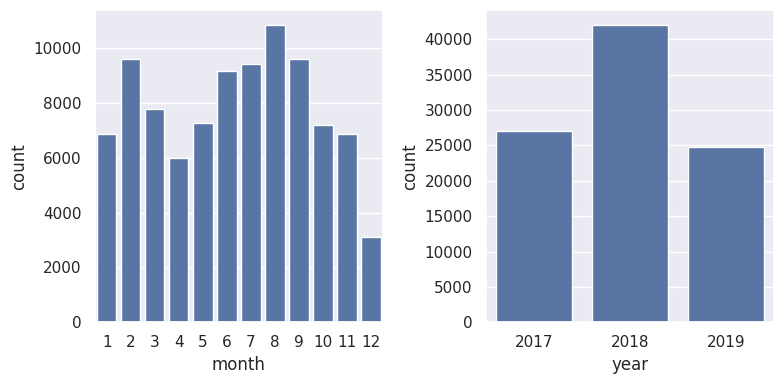

In [22]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
sns.countplot(x="month", data=data)

plt.subplot(122)
sns.countplot(x="year", data=data)

plt.tight_layout()

Analisando as variáveis de mês e ano, observamos que os pedidos são relativamente bem distribuídos ao longo do ano. Além disso, não há tendências claras de crescimento ou queda no número de pedidos no período de 2017 a 2019.

Abaixo, vamos verificar como a proporção de defaults varia ao longo do tempo.

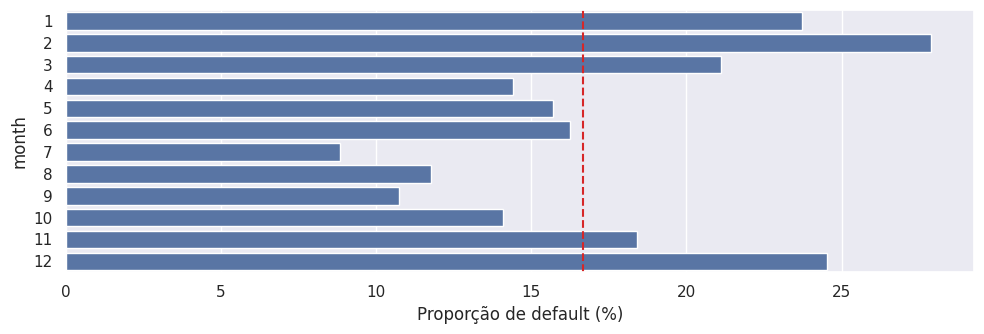

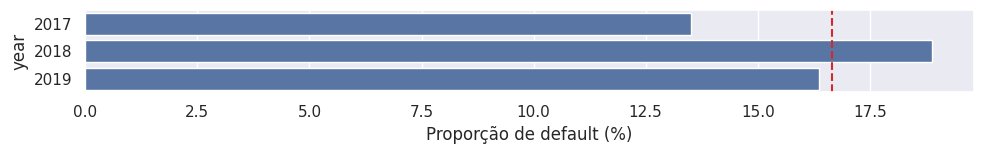

In [23]:
def plot_categorical_vs_default(
    col: str, order: list[str] | None = None, dropna: bool = True
):
    grouped = data.groupby(col, dropna=dropna)
    proportion_default = grouped["default"].mean() * 100
    proportion_default.index = proportion_default.index.fillna("nan")

    plt.figure(figsize=(10, 1.1 + 0.2 * len(proportion_default)))
    sns.barplot(
        x=proportion_default, y=proportion_default.index, order=order, orient="h"
    )
    plt.axvline(x=data["default"].mean() * 100, ls="--", c="tab:red")
    plt.xlabel("Proporção de default (%)")
    plt.tight_layout()


plot_categorical_vs_default("month")
plot_categorical_vs_default("year")

Podemos observar que há menos defaults em pedidos realizados no meio do ano. A seguir, vamos aprofundar a análise utilizando a data completa (mês/ano.)

In [24]:
data["day"] = 1
data["date"] = pd.to_datetime(data[["year", "month", "day"]])
data = data.drop("day", axis=1)

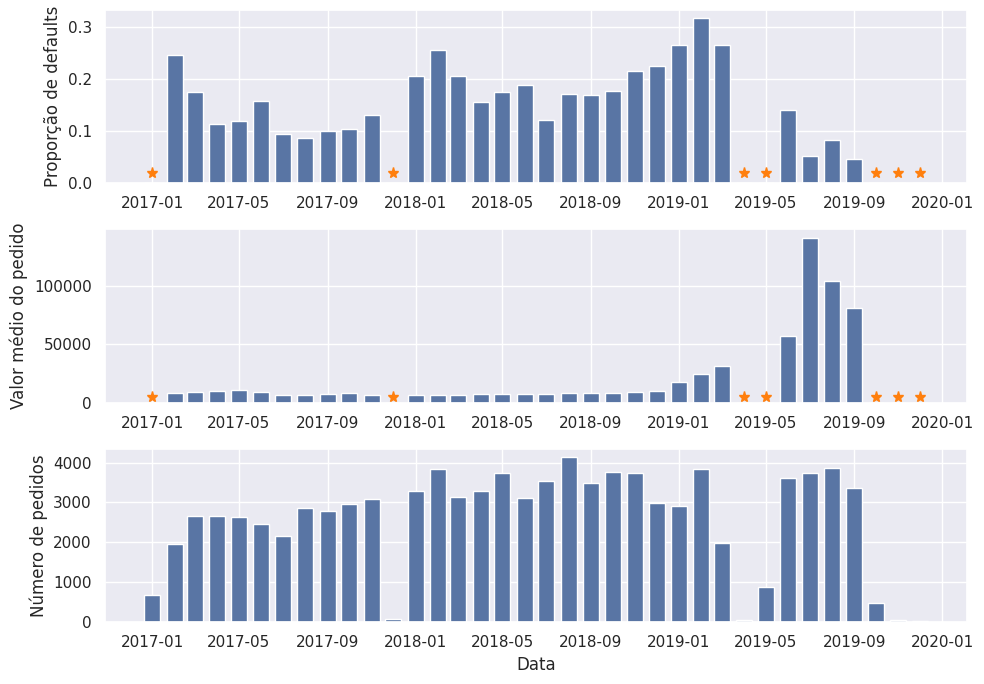

In [25]:
grouped = data.groupby("date").agg(
    {"default": "mean", "valor_total_pedido": "mean", "date": "count"}
).rename(columns={"date": "count"})
grouped.loc[grouped["count"] < 1000, "default"] = 0
grouped.loc[grouped["count"] < 1000, "valor_total_pedido"] = 0

plt.figure(figsize=(10, 7))
plt.subplot(311)
ax = sns.barplot(x="date", y="default", data=grouped, native_scale=True)
for date in grouped.index[grouped["count"] < 1000]:
    ax.plot(date, 0.02, "*", markersize=8, color="tab:orange")
plt.xlabel("")
plt.ylabel("Proporção de defaults")
plt.tight_layout()

plt.subplot(312)
ax = sns.barplot(x="date", y="valor_total_pedido", data=grouped, native_scale=True)
for date in grouped.index[grouped["count"] < 1000]:
    ax.plot(date, 5000, "*", markersize=8, color="tab:orange")
plt.xlabel("")
plt.ylabel("Valor médio do pedido")
plt.tight_layout()

plt.subplot(313)
sns.barplot(x="date", y="count", data=grouped, native_scale=True)
plt.xlabel("Data")
plt.ylabel("Número de pedidos")
plt.tight_layout()

Em alguns meses, houve um número muito baixo de pedidos. Para não enviesar a visualização, esses meses foram excluídos dos gráficos de default e valor. Essa exclusão é indicada pelas estrelas laranjas. As datas em questão são Dez/2017, Abr/2019, Nov/2019 e Dez/2019. Para os meses finais de 2019, podemos imaginar que os dados desses meses ainda não estavam completamente consolidades na construção do dataset.

O gráfico de default mostra que há, de fato, uma redução na quantidade de defaults no meio do ano. Além disso, o gráfico parece indicar uma redução de defaults no final de 2020.

Já o gráfico de valor mostra que o valor médio dos pedidos cresceu significantemente em 2019.

Juntos, os gráficos suportam a conclusão de que a empresa cresceu consideravelmente em 2019 em termos do valor das transações realizadas (sem grande crescimento no número de pedidos) e há indicaões de que, nesse processo, está conseguindo clientes melhores e com menos chance de default.

### Análise de correlação

Para terminar a análise das variáveis numéricas, vou analisar a correlação entre as features e default. Estou utilizando o coeficiente &tau; de Kendall, que mede relações entre variáveis ordinais. Diferente da correlação de Pearson, o coeficiente de Kendall não assume linearidade nem distribuição normal dos dados, tornando-a mais adequada, considerando as distribuições vistas acima.

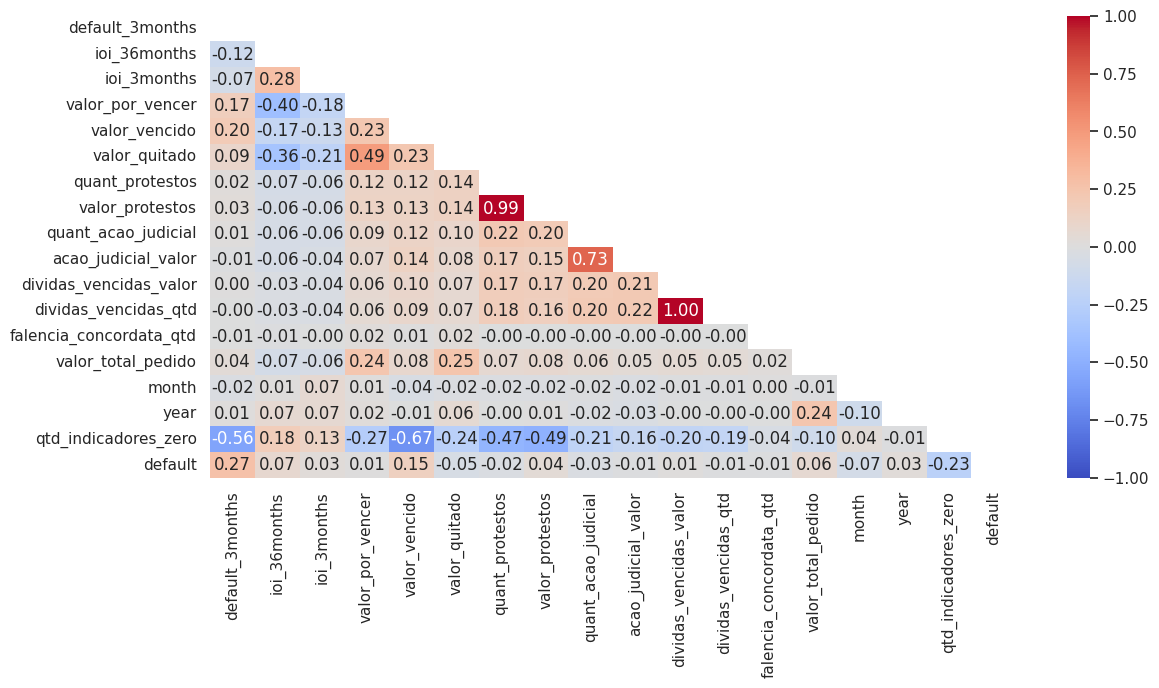

In [26]:
# Move the column default to the right of the dataframe
cols = data.columns.tolist()
cols.remove("default")
cols.append("default")
data = data[cols]

corr = data.corr("kendall", numeric_only=True)
mask = np.tri(corr.shape[0]) - np.eye(corr.shape[0]) == 1
with sns.axes_style("white"):
    plt.figure(figsize=(13, 6))
    sns.heatmap(
        corr,
        mask=~mask,
        vmin=-1,
        vmax=1,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
    )

A matriz de correlação mostra algumas correlações já esperadas entre as variáveis, como:
- `dividas_vencidas_valor` e `dividas_vencidas_qtd` tem correlação alta (acima de 0.995, arredondado para 1.00).
- `qtd_indicadores_zero` tem correlação negativa alta com os indicadores de inadimplência. Isso é esperado, pois quando os indicadores diminuem para zero, a quantidade de indicadores zero aumenta.

Além disso, vemos algumas outras correlações interessantes como:
- O `valor_por_vencer`, o `valor_vencido` e o `valor_quitado` tem correlação negativa com o IOI (tanto o de 3 quanto de 36 meses), indicando que clientes que fizeram mais pedidos recentemente provavelmente fizeram pedidos menores.


P-valor máximo: 0.019901996637777863


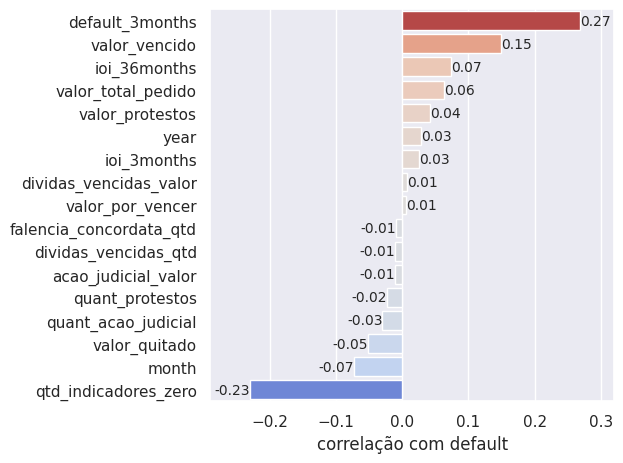

In [27]:
cols = corr.columns.tolist()
cols.remove("default")
corr_default = pd.DataFrame(columns=["corr", "pval"], index=cols)
corr_default.index.name = "variable"

for col in corr_default.index:
    data_clean = data[[col, "default"]].dropna()
    corr_default.loc[col, ["corr", "pval"]] = kendalltau(
        data_clean[col], data_clean["default"], nan_policy="omit"
    )

corr_default = corr_default.sort_values("corr", ascending=False)
print("P-valor máximo:", corr_default["pval"].max())

ax = sns.barplot(
    x="corr",
    y="variable",
    hue="corr",
    data=corr_default,
    palette="coolwarm",
    hue_norm=(-0.3, 0.3),
)
ax.get_legend().remove()
for c in ax.containers:
    plt.bar_label(c, fmt="%.2f", size=10)
plt.xlabel("correlação com default")
plt.ylabel("")
plt.xlim(-0.29, 0.32)
plt.tight_layout()

O gráfico acima mostra a correlação (&tau; de Kendall) entre as diferentes variáveis numéricas e `default`. Todas as correlações tem p < 0.05, e as variáveis mais fortemente correlacionadas são:
- `default_3months` (&tau; = 0.27)
- `qtd_indicadores_zero` (&tau; = -0.23), que foi construída a partir de outras variáveis
- `valor_vencido` (&tau; = 0.15)


## Variáveis Categóricas

Em seguida, passamos às variáveis categóricas.

In [28]:
cat_columns = [
    "tipo_sociedade",
    "opcao_tributaria",
    "atividade_principal",
    "forma_pagamento",
]

num_unique_categories = data[cat_columns].nunique()
num_unique_categories

tipo_sociedade          15
opcao_tributaria         4
atividade_principal    202
forma_pagamento        103
dtype: int64

### Attividade principal

A coluna `atividade_principal` tem 203 categorias. Abaixo, vemos que a maioria dessas atividades tem pouca representatividade no dataset (150 categorias aparecem em menos de 100 transações).

In [29]:
counts = data["atividade_principal"].value_counts()
print("Número de atividades com menos de 100 transações:", (counts < 100).sum())

Número de atividades com menos de 100 transações: 150


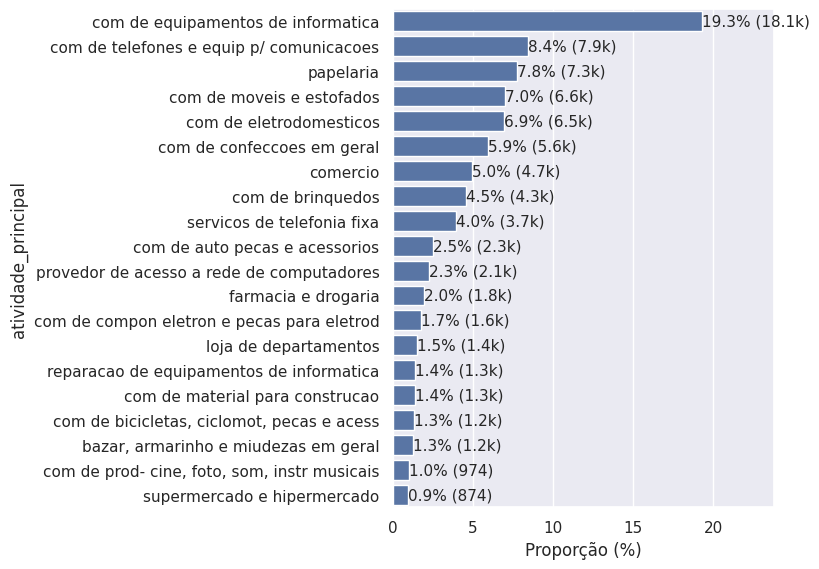

In [30]:
plot_proportions(data["atividade_principal"], limit=20)

Para lidar com isso, vamos agrupar as atividades com base na primeira palavra da atividade, eg:
- "ind de equip para processamento de dados" &rarr; "industria"
- "papelaria" &rarr; "papelaria"
- "com de artigos ortopedicos" &rarr; "comercio"

In [31]:
def simplify_atividade(x: str):
    if pd.isna(x):
        return None
    if m := re.match(r"^\w+", x):
        ativ = x[: m.end()]
        if ativ == "com":
            return "comercio"
        elif ativ == "ind":
            return "industria"
        return ativ


cat_columns.append("atividade_simples")
data["atividade_simples"] = data["atividade_principal"].apply(simplify_atividade)
print("Número de atividades simples:", data["atividade_simples"].nunique())

Número de atividades simples: 61


### Distribuições das variáveis categóricas (exceto forma de pagamento)

Para facilitar a análise das distribuições, vou substituir as categorias com representação menor que 1% por "outro".

In [32]:
for col in (
    "tipo_sociedade",
    "opcao_tributaria",
    "atividade_principal",
    "atividade_simples",
):
    counts = data[col].value_counts(dropna=False)

    # Substitui valores não nulos com contagem < 1% por "outro"
    min_count = 0.01 * len(data)
    mask = (data[col].map(counts) < min_count) & data[col].notna()
    if data.loc[mask, col].unique().shape[0] > 1:
        # Não substitui se houver apenas um valor único com contagem < 1%
        data.loc[mask, col] = "outro"

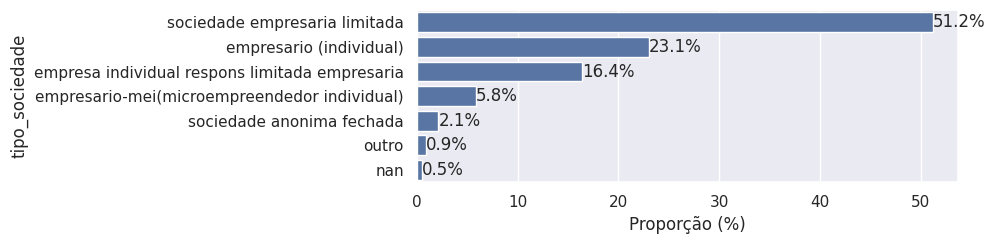

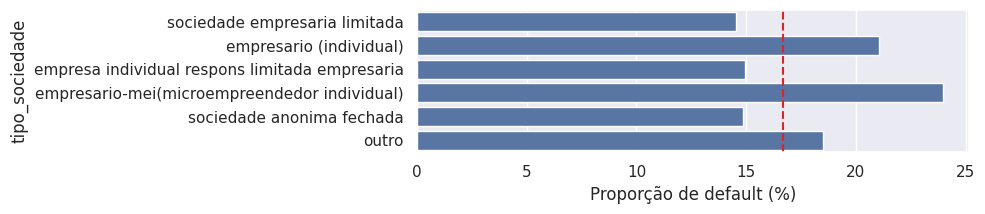

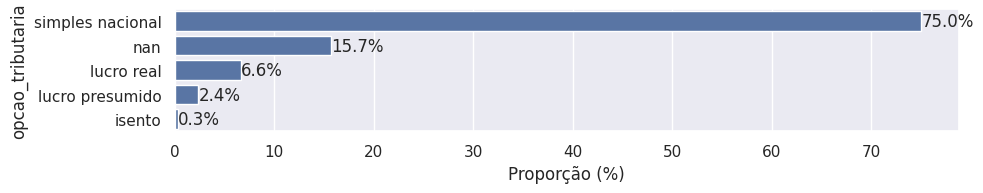

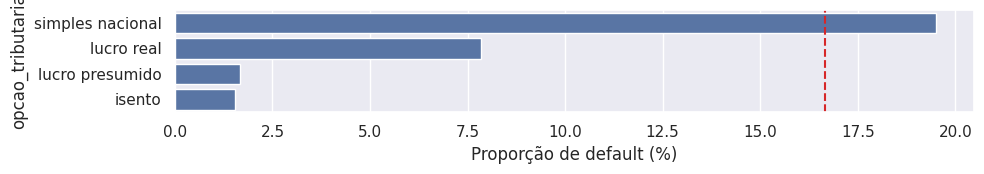

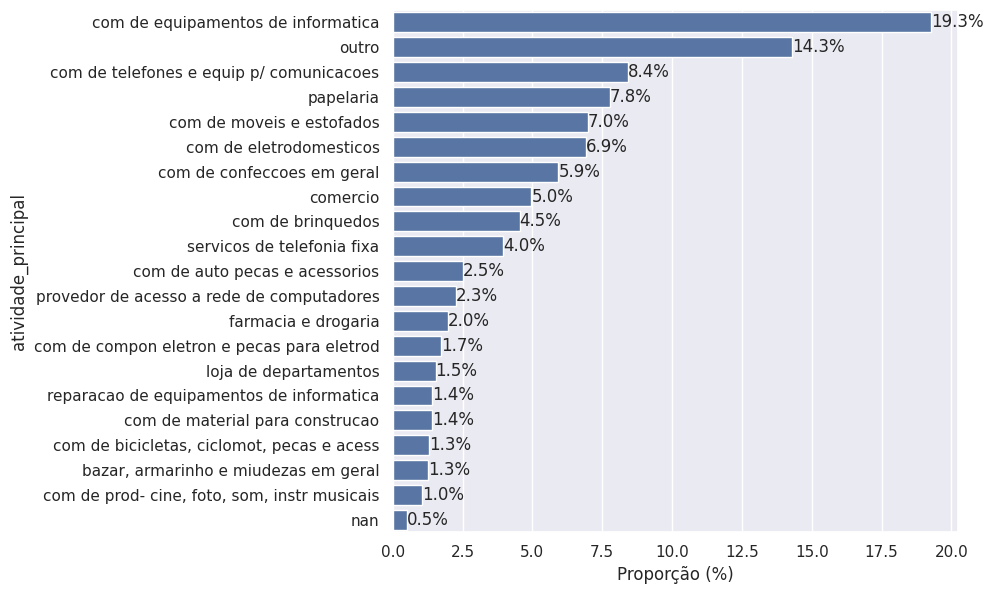

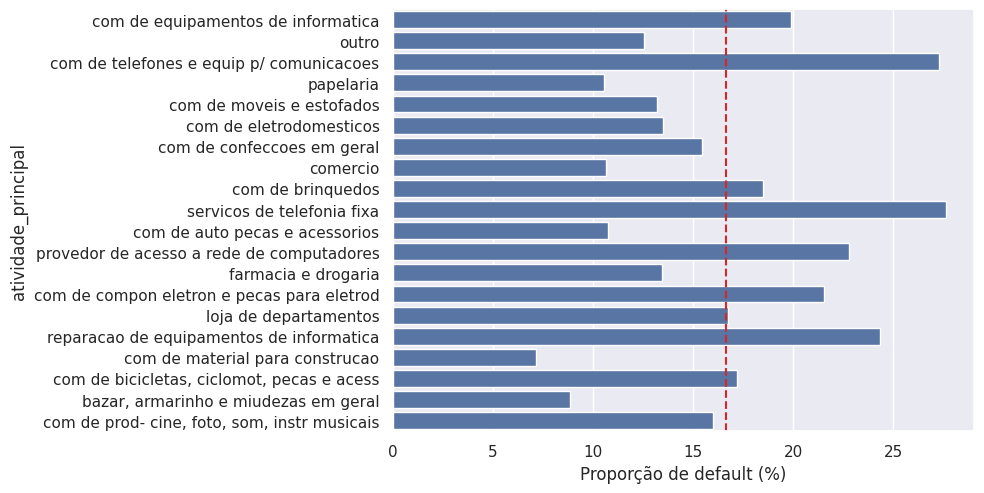

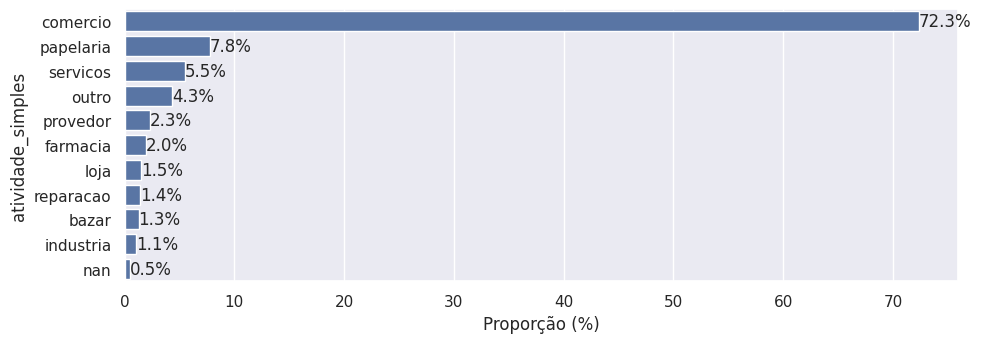

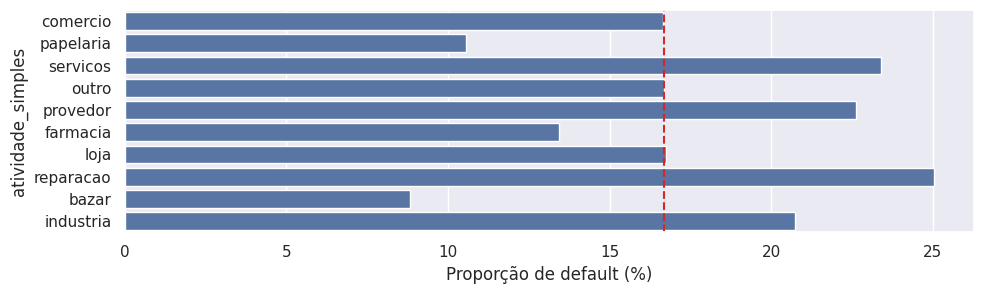

In [33]:
def plot_counts(col: str, dropna: bool=False):
    plt.figure(figsize=(10, 1.1 + 0.25 * data[col].nunique()))
    frequency = data[col].value_counts(normalize=True, dropna=dropna) * 100
    frequency.index = frequency.index.fillna("nan")
    ax = sns.barplot(frequency, orient="h")
    plt.bar_label(ax.containers[0], fmt="%.1f%%")
    plt.xlabel("Proporção (%)")
    plt.ylabel(col)
    plt.tight_layout()

for col in (
    "tipo_sociedade",
    "opcao_tributaria",
    "atividade_principal",
    "atividade_simples",
):
    plot_counts(col)
    counts = data[col].value_counts()
    plot_categorical_vs_default(col, order=counts.index)

Os gráficos acima mostram que as variáveis categóricas são todas correlacionadas com a proporção de default. Nos gráficos de proporção de default, a linha vermelha corresponde à proporção de default no dataset inteiro.

Além disso, os gráficos também mostram que, em geral, as variáveis categóricas são dominadas por um conjunto pequeno de categorias. Esse efeito é particularmente presente na `atividade_simples`, em que 72% dos valores são "comércio". Como a `atividade_principal` é menos desbalanceada, e ainda é correlacionada com o default, parece ser mais apropriado utilizar a atividade principal completa e não a simplificada.

### Forma de Pagamento

In [34]:
print(f"Porcentagem de NaN: {data['forma_pagamento'].isna().mean():.1%}")
data["forma_pagamento"].loc[[10, 52, 1054, 2344, 6039, 77910]]

Porcentagem de NaN: 27.7%


10                 30/60/90
52            boleto 7 dias
1054     12 vezes, 1a, 30dd
2344                    24x
6039         90+10x - 30/30
77910         sem pagamento
Name: forma_pagamento, dtype: object

A variável `forma_pagamento` indica se o pedido será pago em boleto e com qual parcelamento. Por exemplo:

- **"30/60/90"** indica 3 parcelas a serem pagas após 30, 60 e 90 dias
- **"boleto 7 dias"** indica um boleto com vencimento em 7 dias
- **"12 vezes, 1a, 30dd"** indica 12 parcelas, sendo a primeira após 30 dias e próximas a cada 30 dias
- **"24x"** indica 24 parcelas, sem indicação das datas de pagamento
- **"90+10x - 30/30"** indica um primeiro pagamento após 90 dias, seguido de 10 parcelas a cada 30 dias
- **"sem pagamento"** indica que não há pagamento

O código a seguir converte essa coluna para uma representação estruturada, introduzindo as seguintes variáveis:

- `primeira_parcela` - o número de dias até a primeira parcela
- `ultima_parcela` - o número de dias até a última parcela
- `qtd_parcelas` - o número de parcelas
- `is_boleto` - indica se o pagamento será feito em boleto

Quando a forma de pagamento não especifica as datas de pagamento das parcelas (eg. "24x") ou não há pagamento (eg. "sem pagamento"), as duas primeiras variáveis são NaN.

In [47]:
def parse_payment(x: float | str) -> dict:
    """Converte a forma de pagamento para uma representação estruturada.

    Retorna um dicionário com as variáveis descritas acima."""
    if pd.isna(x):
        return {}
    assert isinstance(x, str)

    is_boleto = x.startswith("boleto")
    if is_boleto:
        x = x.removeprefix("boleto").strip()

    if x == "sem pagamento":
        payment_dates = []
    elif x == "a vista":
        payment_dates = [0]
    elif m := re.fullmatch(r"(\d+(?:[/,]\d+)*) ?(?:dias|dd)?", x):
        # Identifica formas de pagamento nos seguintes formatos:
        # - 10/20/30
        # - 10,20,30
        # seguido, opcionalmente, de "dias" ou "dd"
        payment_dates = [int(val) for val in re.split(r"[/,]", m.group(1))]
    elif m := re.fullmatch(r"(\d+) ?(?:x|vezes), ?1a[.,] (\d+)dd", x):
        # Identifica formas de pagamento nos seguintes formatos:
        # - 10x, 1a. 30dd
        # - 10 vezes, 1a. 30dd
        num = int(m.group(1))
        period = int(m.group(2))
        payment_dates = [period * (i + 1) for i in range(num)]
    elif m := re.fullmatch(r"(\d+)\+(\d+)x - (\d+)/(\d+)", x):
        # Identifica formas de pagamento nos seguintes formatos:
        # - 90+10x - 30/30
        first = int(m.group(1))
        num = int(m.group(2))
        period = int(m.group(3))
        payment_dates = [first + period * i for i in range(num + 1)]
    elif m := re.fullmatch(r"(\d+)x(?: \(.*\))?", x):
        # Identifica formas de pagamento nos seguintes formatos:
        # - 10x
        payment_dates = None
    else:
        print("Forma de pagamento não reconhecida:", x)
        return {}

    return {
        "primeira_parcela": payment_dates[0] if payment_dates else np.nan,
        "ultima_parcela": payment_dates[-1] if payment_dates else np.nan,
        "qtd_parcelas": len(payment_dates) if payment_dates is not None else np.nan,
        "is_boleto": int(is_boleto),
    }


# Criar um novo DataFrame manualmente é muito mais rápido do que
# utilizar pd.Series.apply ou pd.Series.map
p = pd.DataFrame(
    data=map(parse_payment, data["forma_pagamento"]),
    index=data.index,
)
data = data.join(p)

Porcentagem de bagamentos em boleto: 0.02701905927094235


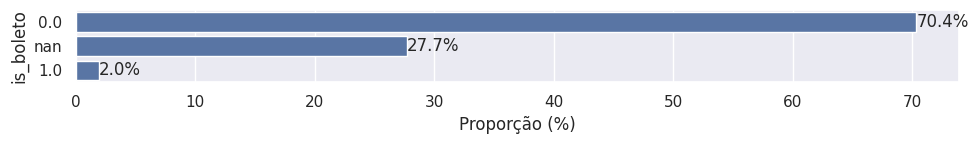

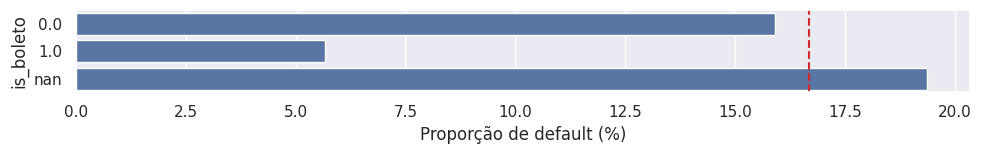

In [36]:
plot_counts("is_boleto", dropna=False)
plot_categorical_vs_default("is_boleto", dropna=False)
print("Porcentagem de bagamentos em boleto:", data["is_boleto"].mean())

Observamos que há muito poucos pagamentos em boleto, mas que eles são em geral mais seguros (menos default) do que outras formas de pagamento.

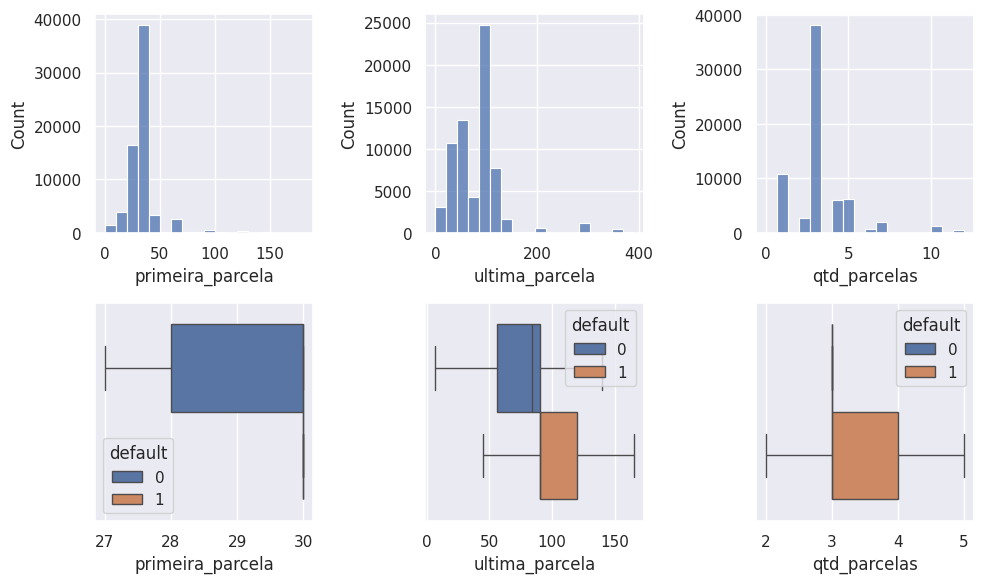

In [37]:
cols = ["primeira_parcela", "ultima_parcela", "qtd_parcelas"]

plt.figure(figsize=(10, 6))
for i, col in enumerate(cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(x=col, bins="sturges", data=data)

    plt.subplot(2, 3, i + 4)
    sns.boxplot(x=col, data=data, hue="default", showfliers=False)

plt.tight_layout()


Os boxplots acima não incluem outliers.

As variáveis relacionadas às parcelas são bem distribuídas e tem capacidade de distinguir entre default e não default. Em particular, observamos que pedidos com default geralmente tem um maior número de parcelas. Além disso, nesses pedidos o pagamento começa (primeira parcela) e termina (última parcela) mais tarde.

P-valor máximo: 0.019901996637777863


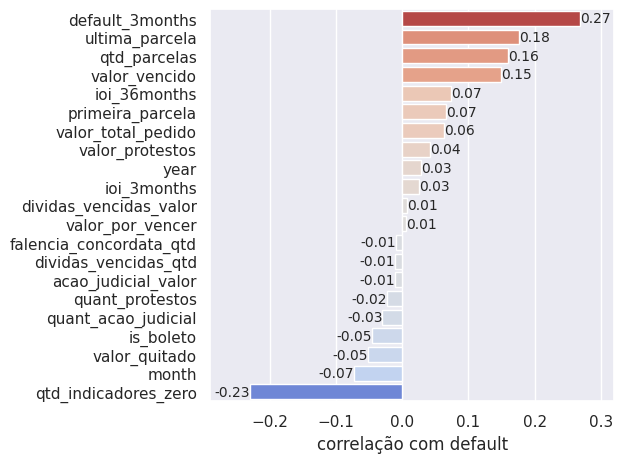

In [38]:
cols = data.select_dtypes(["float64", "int64"]).columns.tolist()
cols.remove("default")
corr_default = pd.DataFrame(columns=["corr", "pval"], index=cols)
corr_default.index.name = "variable"

for col in corr_default.index:
    data_clean = data[[col, "default"]].dropna()
    corr_default.loc[col, ["corr", "pval"]] = kendalltau(
        data_clean[col], data_clean["default"], nan_policy="omit"
    )

corr_default = corr_default.sort_values("corr", ascending=False)
print("P-valor máximo:", corr_default["pval"].max())

ax = sns.barplot(
    x="corr",
    y="variable",
    hue="corr",
    data=corr_default,
    palette="coolwarm",
    hue_norm=(-0.3, 0.3),
)
ax.get_legend().remove()
for c in ax.containers:
    plt.bar_label(c, fmt="%.2f", size=10)
plt.xlabel("correlação com default")
plt.ylabel("")
plt.xlim(-0.29, 0.32)
plt.tight_layout()

Reanalisando a correlação das variáveis numéricas com default, vemos que as novas variáveis tem correlação considerável com default. Em especial, `ultima_parcela` e `qtd_parcelas` estão entre as 4 variáveis com maior correlação.

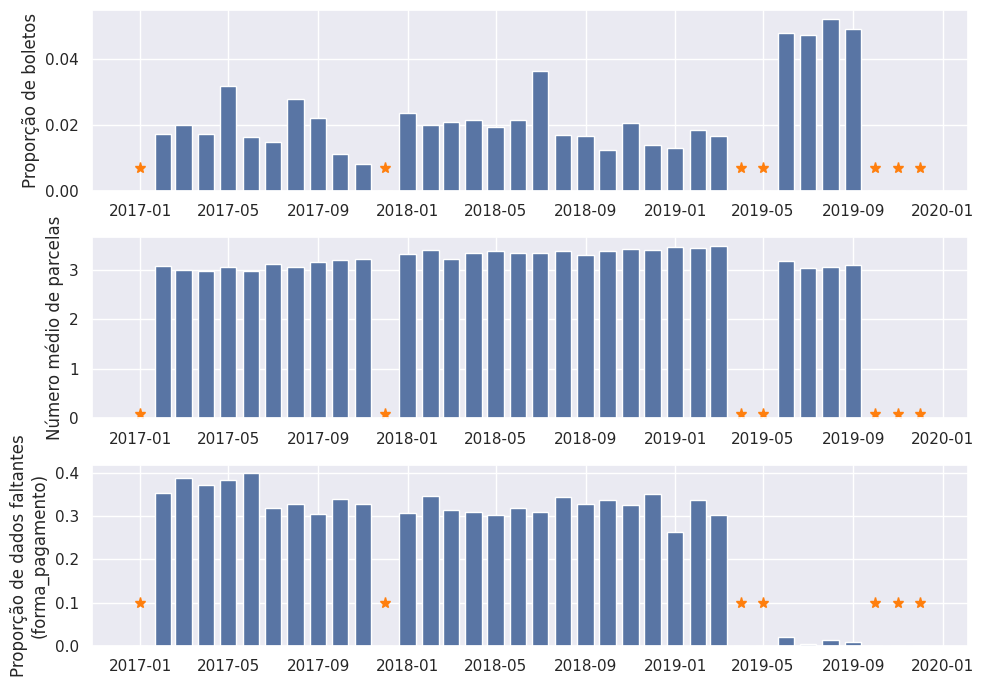

In [39]:
data["forma_pagamento_nan"] = data["forma_pagamento"].isna().astype("int")

grouped = (
    data.groupby("date")
    .agg(
        {
            "is_boleto": "mean",
            "qtd_parcelas": "mean",
            "forma_pagamento_nan": "mean",
            "date": "count",
        }
    )
    .rename(columns={"date": "count"})
)
grouped.loc[grouped["count"] < 1000, "is_boleto"] = 0
grouped.loc[grouped["count"] < 1000, "qtd_parcelas"] = 0
grouped.loc[grouped["count"] < 1000, "forma_pagamento_nan"] = 0

plt.figure(figsize=(10, 7))
plt.subplot(311)
ax = sns.barplot(x="date", y="is_boleto", data=grouped, native_scale=True)
for date in grouped.index[grouped["count"] < 1000]:
    ax.plot(date, 0.007, "*", markersize=8, color="tab:orange")
plt.xlabel("")
plt.ylabel("Proporção de boletos")
plt.tight_layout()

plt.subplot(312)
ax = sns.barplot(x="date", y="qtd_parcelas", data=grouped, native_scale=True)
for date in grouped.index[grouped["count"] < 1000]:
    ax.plot(date, 0.1, "*", markersize=8, color="tab:orange")
plt.xlabel("")
plt.ylabel("Número médio de parcelas")

plt.subplot(313)
ax = sns.barplot(x="date", y="forma_pagamento_nan", data=grouped, native_scale=True)
for date in grouped.index[grouped["count"] < 1000]:
    ax.plot(date, 0.1, "*", markersize=8, color="tab:orange")
plt.xlabel("")
plt.ylabel("Proporção de dados faltantes\n(forma_pagamento)")

plt.tight_layout()

Por fim, podemos tendências a forma de pagamento no final de 2019. Devido à baixa quantidade de dados nos últimos meses, não é possível tirar grandes conclusões, mas os gráficos mostram claramente a queda no número de valores faltantes no final de 2019, o que pode indicar uma mudança na coleta de dados por parte da empresa. Além disso, podemos ver tendências de queda no número de parcelas no final de 2019 e aumento no número de boletos, mas essas tendências podem ser devidas à melhoria na coleta de dados.

Por fim, vou verificar se essa redução de dados faltantes também se reflete na opção tributária, que também tem uma grande quantidade de nans.

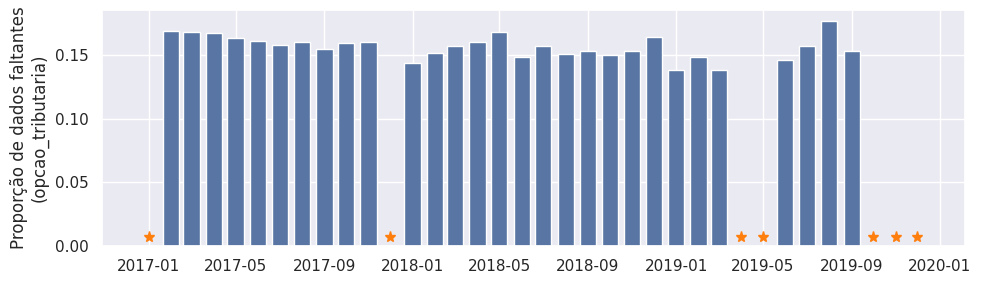

In [40]:
data["opcao_tributaria_nan"] = data["opcao_tributaria"].isna().astype("int")

grouped = (
    data.groupby("date")
    .agg({"opcao_tributaria_nan": "mean", "date": "count"})
    .rename(columns={"date": "count"})
)
grouped.loc[grouped["count"] < 1000, "opcao_tributaria_nan"] = 0

plt.figure(figsize=(10, 3))
ax = sns.barplot(x="date", y="opcao_tributaria_nan", data=grouped, native_scale=True)
for date in grouped.index[grouped["count"] < 1000]:
    ax.plot(date, 0.007, "*", markersize=8, color="tab:orange")
plt.xlabel("")
plt.ylabel("Proporção de dados faltantes\n(opcao_tributaria)")
plt.tight_layout()

Observamos que a resposta é não: não há redução nos dados faltantes para a opção tributária. Logo, a variação observada na forma de pagamento é provavelmente devida a alguma alteração realizada especificamente na coleta de dados de pagamento.